# Import Libraries

In [104]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import numpy as np

# Model

In [105]:
 # Create a model
model = grb.Model("Model")

# Get data from json

In [106]:
# get the  data from the json file small.json
import json
with open('small.json') as f:
    data = json.load(f)
data

{'horizon': 5,
 'qualifications': ['A', 'B', 'C'],
 'staff': [{'name': 'Olivia',
   'qualifications': ['A', 'B', 'C'],
   'vacations': []},
  {'name': 'Liam', 'qualifications': ['A', 'B'], 'vacations': [1]},
  {'name': 'Emma', 'qualifications': ['C'], 'vacations': [2]}],
 'jobs': [{'name': 'Job1',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 1, 'C': 1}},
  {'name': 'Job2',
   'gain': 15,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 2}},
  {'name': 'Job3',
   'gain': 15,
   'due_date': 4,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'C': 2}},
  {'name': 'Job4',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'B': 2, 'C': 1}},
  {'name': 'Job5',
   'gain': 10,
   'due_date': 5,
   'daily_penalty': 3,
   'working_days_per_qualification': {'C': 2}}]}

## Constants from data

In [107]:
horizon= data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications=[i['qualifications'] for i in data['staff']]
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=[i['daily_penalty'] for i in data['jobs']] 
job_qualifications= [i['working_days_per_qualification'] for i in data['jobs']]
job_gain=[i['gain'] for i in data['jobs']]
due_dates=[i['due_date'] for i in data['jobs']]
vacation_staff=[i['vacations'] for i in data['staff']]

# Model's parameters

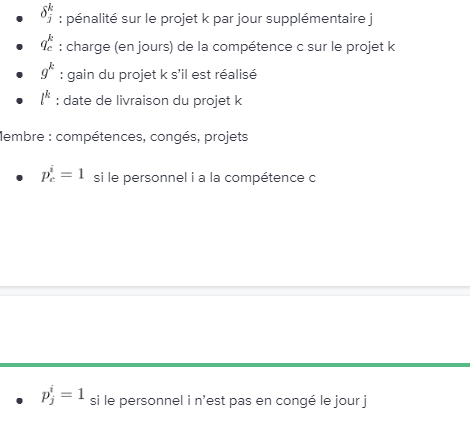

In [108]:
# create a function that converts a dictionary to a matrix
def get_matrix(liste):
    test=pd.DataFrame.from_dict(liste,orient='index')
    test.fillna(0,inplace=True)
    return test.to_dict(orient='index')

In [109]:
# create dictionaries with job_list as key and job_penality, job_gain ans due_dates as values
gammak=job_penality_dict=dict(zip(job_list,job_penality))
gk=job_gain_dict=dict(zip(job_list,job_gain))
lk=due_dates_dict=dict(zip(job_list,due_dates))

# create a dictionary for staff qualifications
pi_c = {}
for i in range(len(staff_names)) :
    k = staff_names[i]
    pi_c[k] = {}
    for c in qualifications:
        if c in data['staff'][i]['qualifications']:
            pi_c[k][c] = 1
        else:
            pi_c[k][c] = 0
qk_c=get_matrix(dict(zip(job_list,job_qualifications)))
# get pi_j
staff_in_vacation=pd.DataFrame(index=staff_names,columns=jour_list)
# fill the dataframe staff_in_vacation with the svalues of the dictionary
for i in staff_names:
    for j in jour_list:
        staff_in_vacation.loc[i,j]=0 if j in dict(zip(staff_names,vacation_staff))[i] else 1
pi_j=staff_in_vacation.to_dict(orient='index')

# Decision variables

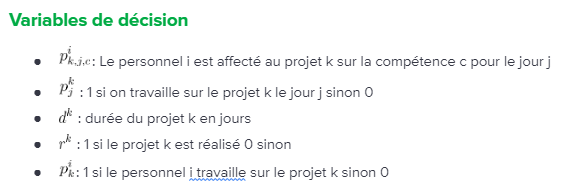

In [110]:
# constraint M1 and M2
M2=1
M1=horizon*len(qualifications)
M3 = 2

In [111]:
# Add decision variables
# pi_k_j_c: Le personnel i est affecté au projet k sur la compétence c pour le jour j
pi_k_j_c = model.addVars(staff_names,job_list,jour_list,qualifications, vtype=GRB.BINARY, name="pi_k_j_c")

# pk_j : 1 si on travaille sur le projet k le jour j sinon 0
zk_j = model.addVars(job_list,jour_list,vtype=GRB.BINARY, name="zk_j")

# pour la linéarisation de l'objectif 1
tk=model.addVars(job_list,vtype=GRB.INTEGER, name="tk")

# rk : 1 si le projet k est réalisé 0 sinon
rk = model.addVars( job_list,vtype=GRB.BINARY, name="rk")
# rk_c = model.addVars(job_list,qualifications,vtype=GRB.BINARY, name="rk_c")

# deltak = model.addVars( job_list,vtype=GRB.BINARY, name="deltak")
delta_k_c = model.addVars(job_list,qualifications,vtype=GRB.BINARY, name="delta_k_c")
delta_k_j = model.addVars(job_list,jour_list,vtype=GRB.BINARY, name="delta_k_j")

# pi_k : 1 si le personnel i est affecté au projet k 0 sinon
#pi_k = model.addVars( staff_names,job_list,vtype=GRB.BINARY, name="dk")


# Constraints

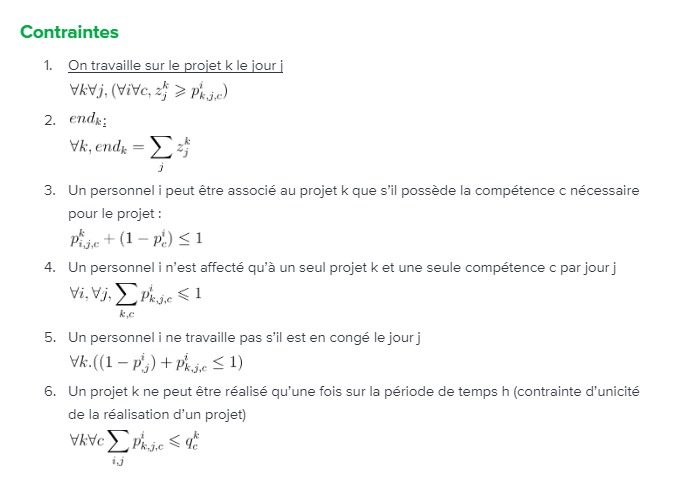

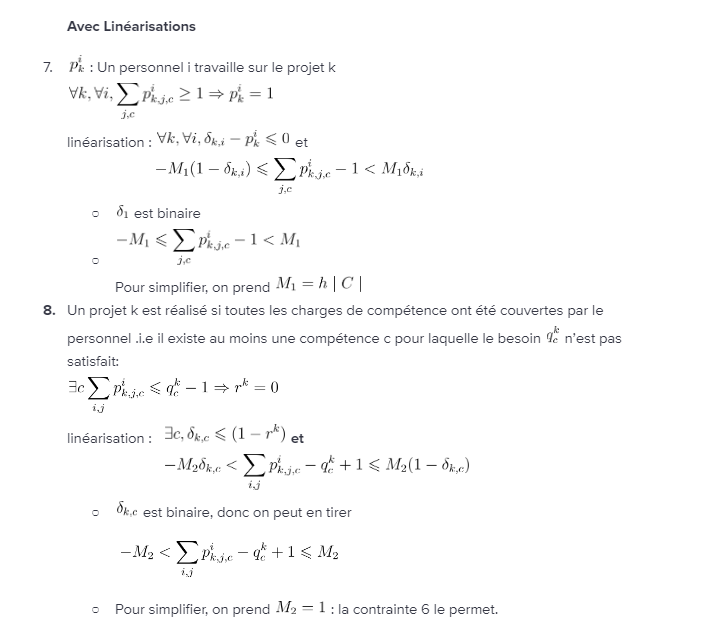

In [112]:
#Un personnel i peut être associé au projet k que s’il possède la compétence c nécessaire pour le projet :
constr1={f'p{i}_{k}_{j}_{c}':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_c[i][c]) <=1, name=f"contrainte1{i}_{k}_{j}_{c}")
    for i in staff_names for k in job_list 
       for j in jour_list  for c in qualifications }
constr2={f'p{i}_{j}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for k in job_list for c in qualifications) <=1, name=f"contrainte2{i}_{j}")
    for i in staff_names for j in jour_list}
constr3={f'2p{i}_{k}_{j}_{c}':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_j[i][j]) <=1, name=f"contrainte3{i}_{k}_{j}_{c}")
    for i in staff_names for k in job_list 
       for j in jour_list  for c in qualifications }
constr4={f'p{i}':model.addConstr(delta_k_c[k,c] <= (1 - rk[k]) , name = f"contrainte4{i}")
        for i in range(len(job_list))
        for k in job_list
        for c in qualifications
        } 

constr5 = {f'p{k}_{c}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) - qk_c[k][c] + 1 <= (1 - delta_k_c[k,c]) , name = f"contrainte5{k}_{c}")
        for k in job_list
          for c in qualifications}

constr6 = {f'p2{k}_{c}':model.addConstr( -delta_k_c[k,c] +0.01<= grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) - qk_c[k][c] + 1   , name = f"contrainte6{k}_{c}")
        for k in job_list
          for c in qualifications} 
#######################    
#######################
#######################
constr8={f'z{k}_{j}_{i}_{c}':model.addConstr(pi_k_j_c[i,k,j,c] <= zk_j[k,j] , name=f"contrainte8z{k}_{j}_{i}_{c}")
    for i in staff_names for c in qualifications
        for k in job_list for j in jour_list}
contr8={f'2t{k}':model.addConstr(tk[k]>= 0, name=f"contrainte8t{k}")
    for k in job_list }

contr9={f't{k}':model.addConstr(tk[k]>= job_penality_dict[k]*(grb.quicksum(zk_j[k,j] for j in jour_list)-due_dates_dict[k]), name=f"contrainte9t{k}")
    for k in job_list }

# const11={f'z2{k}_{j}':model.addConstr( delta_k_j[k,j] - zk_j[k,j]<= 0   , name = f"contrainte11Z{k}_{j}")
#         for k in job_list
#           for j in jour_list}
          
# const12 = {f'delta{k}_{j}':model.addConstr(- M3*(1-delta_k_j[k,j]) <= grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for c in qualifications) - 1 , name = f"contrainte12{k}_{j}")
#         for k in job_list
#           for j in jour_list}

# const13= {f'delta2{k}_{j}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for c in qualifications) - 1 <= M3*delta_k_j[k,j], name = f"contrainte13{k}_{j}")
#         for k in job_list
#           for j in jour_list}

In [113]:
job_gain_dict

{'Job1': 20, 'Job2': 15, 'Job3': 15, 'Job4': 20, 'Job5': 10}

In [114]:
# Fonction Objectif
model.setObjective(grb.quicksum((job_gain_dict[k]*rk[k]) - tk[k] for k in job_list), GRB.MAXIMIZE)  
# model.setObjective(grb.quicksum((tk[k]) for k in job_list), GRB.MINIMIZE)  

# Paramétrage (mode mute)
model.params.outputflag = 0
# Résolution du PL
model.optimize()

In [115]:
#model.computeIIS()
model.write("model.lp")
#  print constraints of the gurobipy.Model

In [116]:
model.ObjVal

70.0

In [117]:
values= []
for k, v in pi_k_j_c.items():
    values.append(v.x)

In [118]:
tk

{'Job1': <gurobi.Var tk[Job1] (value -0.0)>,
 'Job2': <gurobi.Var tk[Job2] (value 0.0)>,
 'Job3': <gurobi.Var tk[Job3] (value 0.0)>,
 'Job4': <gurobi.Var tk[Job4] (value 0.0)>,
 'Job5': <gurobi.Var tk[Job5] (value -0.0)>}

In [119]:
res = pd.DataFrame(list(pi_k_j_c.keys()))
res[4] = values
result = res[res[4] == 1]
result

,0,1,2,3,4
6,Olivia,Job1,3,A,1.0
16,Olivia,Job2,1,B,1.0
24,Olivia,Job2,4,A,1.0
35,Olivia,Job3,2,C,1.0
58,Olivia,Job4,5,B,1.0
82,Liam,Job1,3,B,1.0
100,Liam,Job2,4,B,1.0
108,Liam,Job3,2,A,1.0
133,Liam,Job4,5,B,1.0
158,Emma,Job1,3,C,1.0


## Result Table

In [120]:
def color_table(x):
    if pd.isna(x):
        return "background-color: white"
    else:
        if "Job1" in x :
            return "background-color: blue"
        elif "Job2" in x:
            return "background-color: black"
        elif "Job3" in x:
            return "background-color: orange"
        elif "Job4" in x:
           return "background-color: grey"
        elif "Job5" in x:
           return "background-color: green"
        else:
           return  "background-color: red"

In [121]:
df = pd.DataFrame(columns = [i for i in range(1,6)], index = staff_names)

for ind, val in result.iterrows():
    col = val[2]
    row = val[0]
    v = val[3] + " " + val[1]
    df.loc[row,col] = v
    # vacation
    for staff in staff_names:
        for day in jour_list:
            if pi_j[staff][day] == 0:
                df.loc[staff,day] = 'X'
df.style.applymap(color_table)

,1,2,3,4,5
Olivia,B Job2,C Job3,A Job1,A Job2,B Job4
Liam,X,A Job3,B Job1,B Job2,B Job4
Emma,C Job4,X,C Job1,C Job5,C Job3


In [122]:
for s in staff_names:
    for c in  qualifications:
        print(pi_k_j_c[s,'Job1',1,c])

<gurobi.Var pi_k_j_c[Olivia,Job1,1,A] (value -0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,1,B] (value -0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,1,C] (value -0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,1,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,1,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,1,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,1,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,1,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,1,C] (value -0.0)>


In [123]:
zk_j

{('Job1', 1): <gurobi.Var zk_j[Job1,1] (value -0.0)>,
 ('Job1', 2): <gurobi.Var zk_j[Job1,2] (value -0.0)>,
 ('Job1', 3): <gurobi.Var zk_j[Job1,3] (value 1.0)>,
 ('Job1', 4): <gurobi.Var zk_j[Job1,4] (value -0.0)>,
 ('Job1', 5): <gurobi.Var zk_j[Job1,5] (value -0.0)>,
 ('Job2', 1): <gurobi.Var zk_j[Job2,1] (value 1.0)>,
 ('Job2', 2): <gurobi.Var zk_j[Job2,2] (value -0.0)>,
 ('Job2', 3): <gurobi.Var zk_j[Job2,3] (value 0.0)>,
 ('Job2', 4): <gurobi.Var zk_j[Job2,4] (value 1.0)>,
 ('Job2', 5): <gurobi.Var zk_j[Job2,5] (value 1.0)>,
 ('Job3', 1): <gurobi.Var zk_j[Job3,1] (value -0.0)>,
 ('Job3', 2): <gurobi.Var zk_j[Job3,2] (value 1.0)>,
 ('Job3', 3): <gurobi.Var zk_j[Job3,3] (value -0.0)>,
 ('Job3', 4): <gurobi.Var zk_j[Job3,4] (value -0.0)>,
 ('Job3', 5): <gurobi.Var zk_j[Job3,5] (value 1.0)>,
 ('Job4', 1): <gurobi.Var zk_j[Job4,1] (value 1.0)>,
 ('Job4', 2): <gurobi.Var zk_j[Job4,2] (value -0.0)>,
 ('Job4', 3): <gurobi.Var zk_j[Job4,3] (value -0.0)>,
 ('Job4', 4): <gurobi.Var zk_j[Job4,